In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, GridSearchCV, train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline

# Data import

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
def plot_missing_values_from_dataset(dataset, name):
    fig, ax = plt.subplots(figsize=(20,10))
    bars = ax.bar(
        dataset.isnull().sum().index,
        dataset.isnull().sum().values,
        color ='yellow',
        edgecolor='blue'
    )
    ax.set_title(f'Missing values in {name} dataset')
    ax.set_xlabel('Feature names')
    ax.set_ylabel('Amount of missing')
    ax.set_xticklabels(
        dataset.isnull().sum().index, rotation=90, fontsize=10
    )
    ax.set_yticks(np.arange(0, 1600, 100))
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(axis='y')
    plt.margins(0.01, 0.05)

# Missing values from train dataset

<ipython-input-8-1b6fe1847b48>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


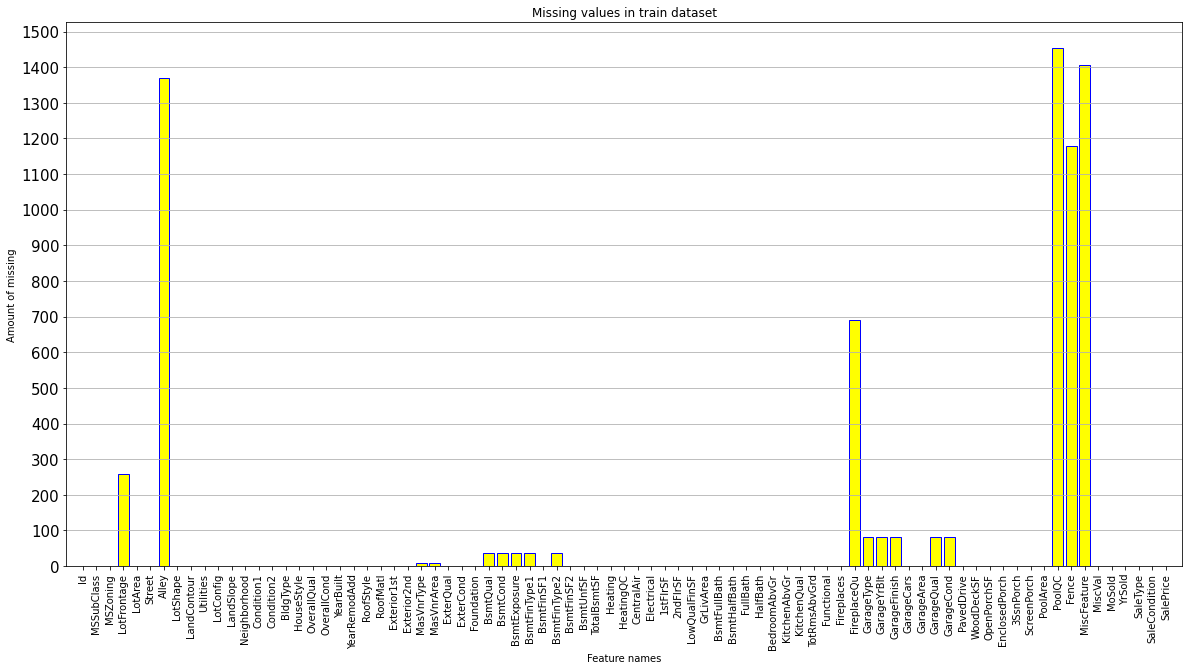

In [9]:
plot_missing_values_from_dataset(train, 'train')

# Missing values from test dataset

<ipython-input-12-a8f9ff196ca5>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


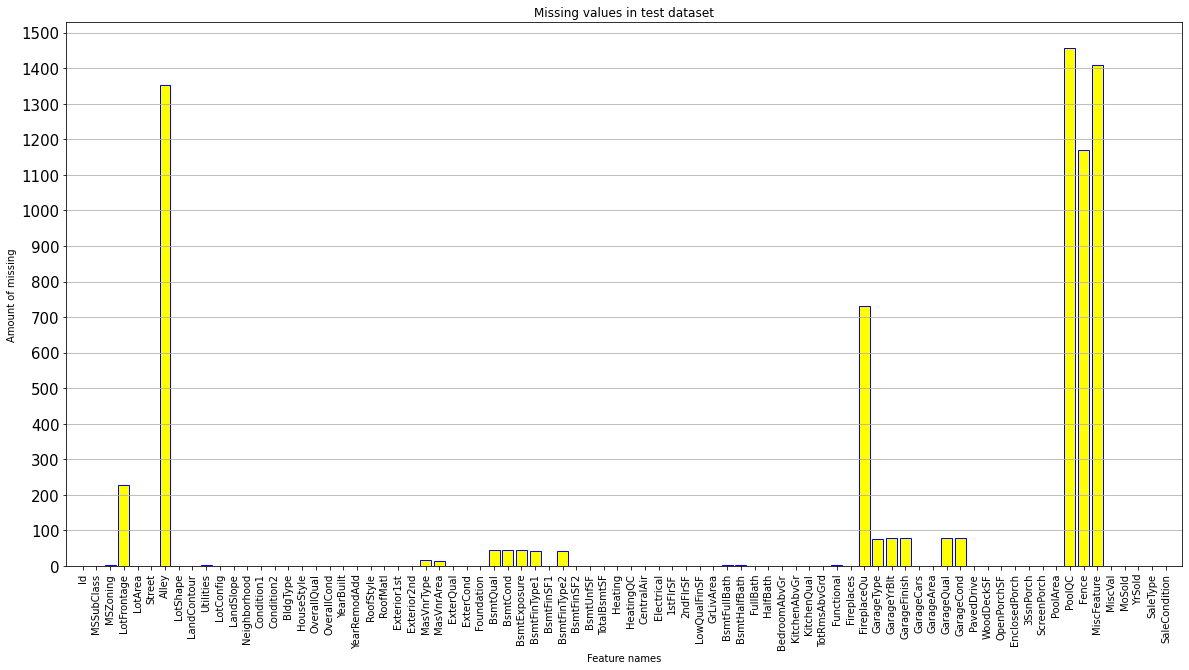

In [13]:
plot_missing_values_from_dataset(test, 'test')

In [19]:
def plot_features_with_missing_values(dataset, name):
    fig, ax = plt.subplots(figsize=(20,10))
    bars = ax.bar(
        dataset.loc[:, dataset.isnull().sum() > 0].isnull().sum().index,
        dataset.loc[:, dataset.isnull().sum() > 0].isnull().sum().values,
        color='yellow',
        edgecolor='blue'
    )
    ax.set_title(f'Features with missing values in the {name} dataset', fontsize=30, pad=15)
    ax.set_xlabel("Feature with missing values names", fontsize=20, labelpad=15)
    ax.set_ylabel("Amount of values missing", fontsize=20, labelpad=15)
    ax.set_yticks(np.arange(0, 1600, 100))
    ax.set_xticklabels(dataset.loc[:, dataset.isnull().sum()>0].isnull().sum().index,
                       fontsize=15, rotation = 60, ha="right", rotation_mode='anchor')
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(axis="y")
    plt.margins(0.01, 0.05)

<ipython-input-19-580d88dad5cc>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataset.loc[:, dataset.isnull().sum()>0].isnull().sum().index,
<ipython-input-19-580d88dad5cc>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dataset.loc[:, dataset.isnull().sum()>0].isnull().sum().index,


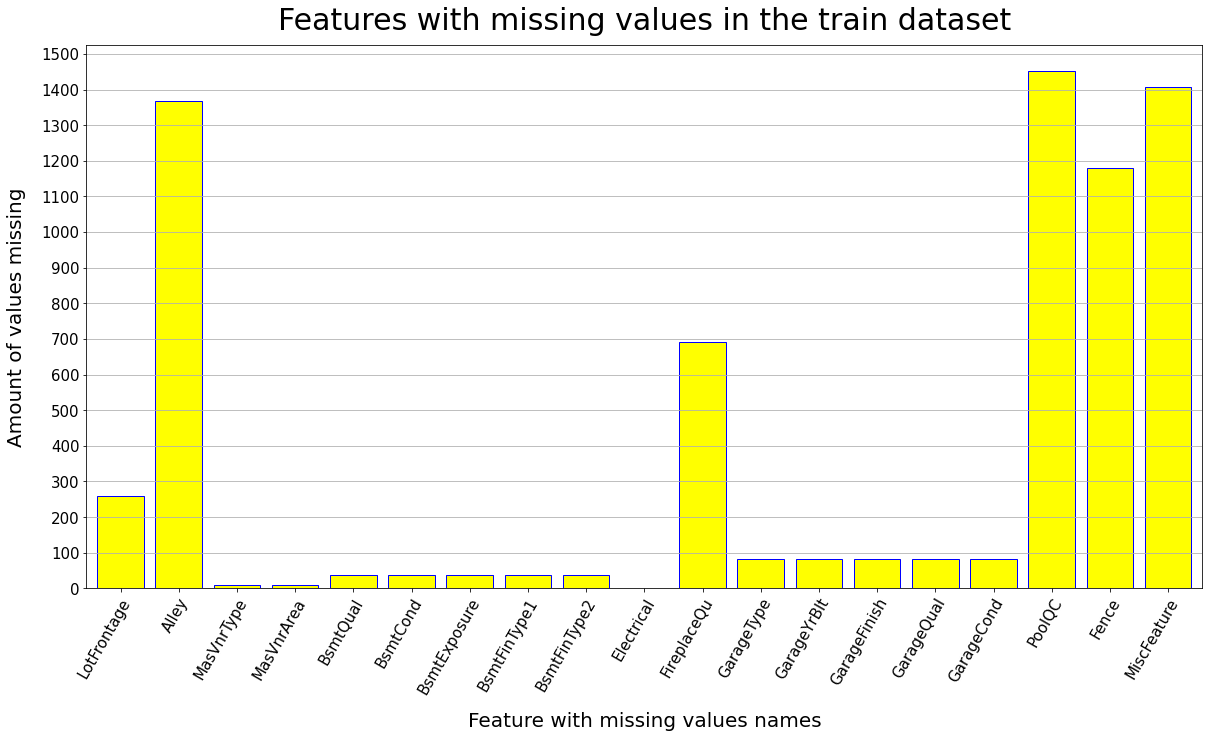

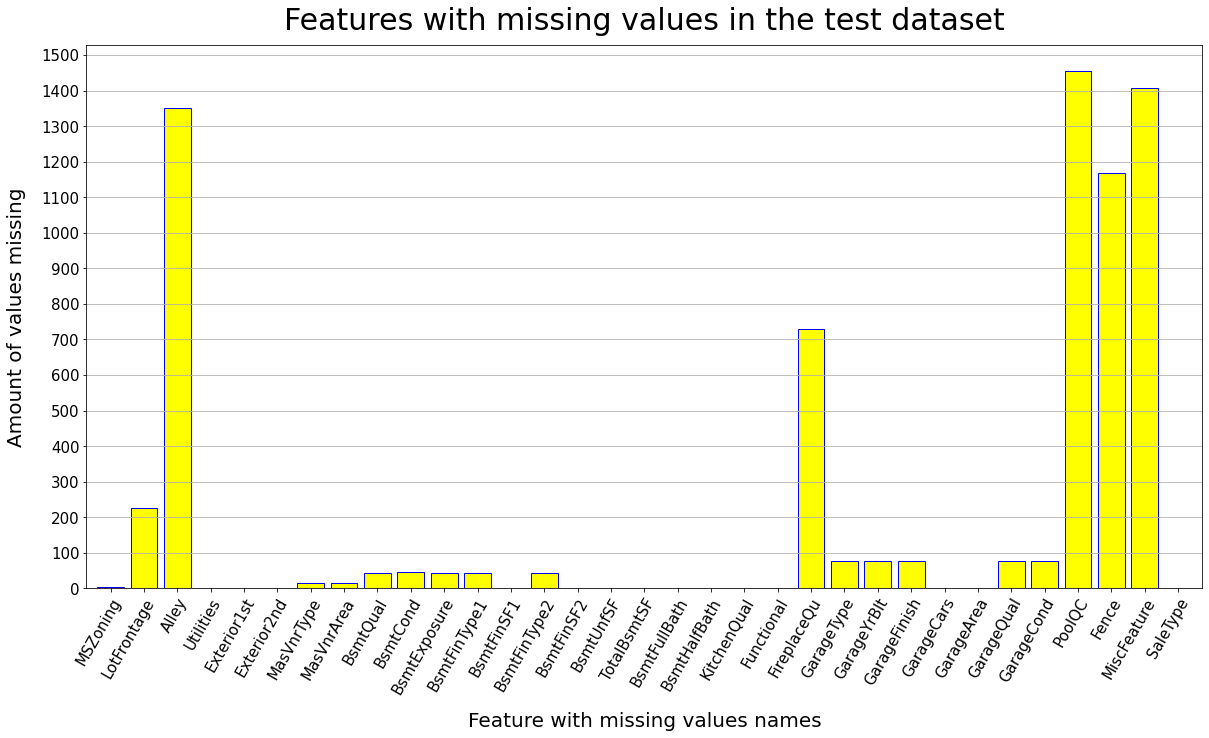

In [21]:
plot_features_with_missing_values(train, 'train')
plot_features_with_missing_values(test, 'test')

In [22]:
pd.concat([train.drop("SalePrice", axis=1).isna().sum(), test.isna().sum()], axis=1).T

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,0,0,259,0,0,1369,0,0,0,...,0,0,1453,1179,1406,0,0,0,0,0
1,0,0,4,227,0,0,1352,0,0,2,...,0,0,1456,1169,1408,0,0,0,1,0


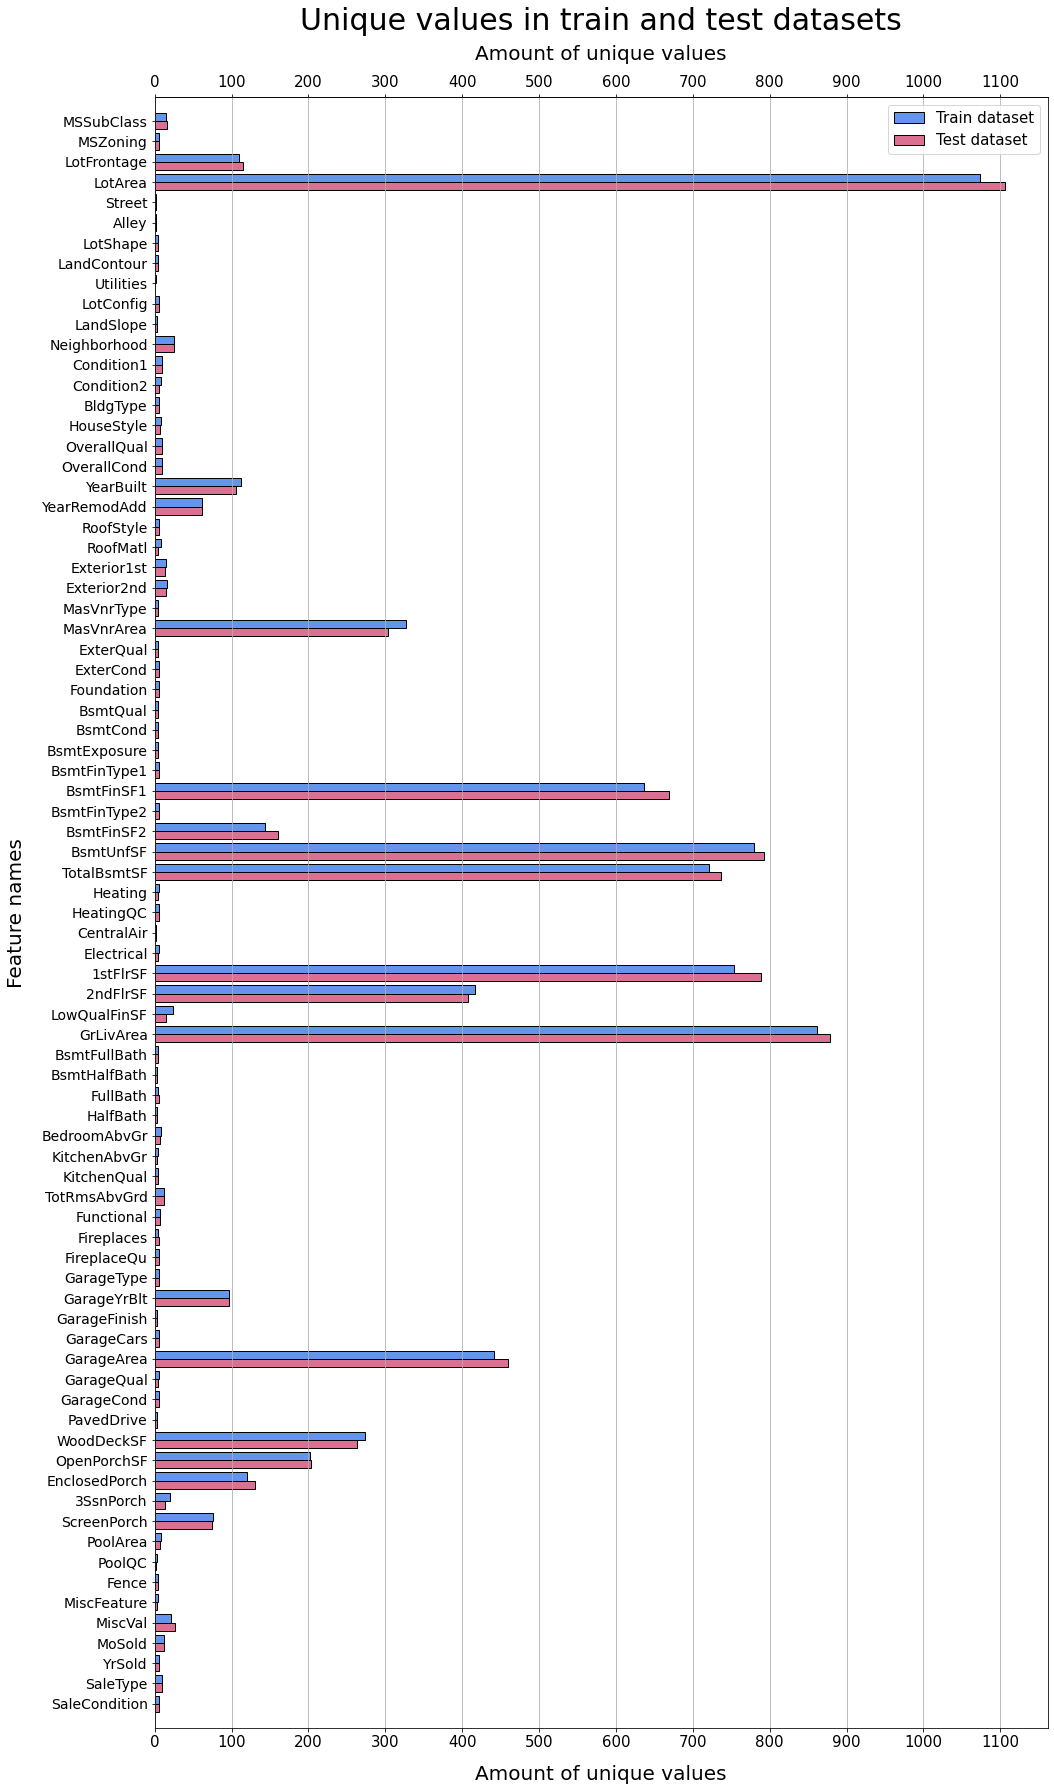

In [23]:
x = -1*np.arange(len(test.drop(["Id"], axis=1).columns))

fig, ax = plt.subplots(figsize=(16, 30))
bars = ax.barh(x+0.2, train.drop(["Id", "SalePrice"], axis=1).nunique().values,
               height=0.4, color="cornflowerblue", label="Train dataset", edgecolor="black")
bars2 = ax.barh(x-0.2, test.drop(["Id"], axis=1).nunique().values,
                height=0.4, color="palevioletred", label="Test dataset", edgecolor="black")
ax.set_title("Unique values in train and test datasets", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Amount of unique values", fontsize=20, labelpad=15)
ax.set_xticks(np.arange(0, 1600, 100))
ax.set_yticks(x)
ax.set_yticklabels(list(test.drop(["Id"], axis=1).columns.values))
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=14)
ax.grid(axis="x")
ax.legend(fontsize=15)
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.arange(0, 1600, 100))
ax2.set_xlabel("Amount of unique values", fontsize=20, labelpad=15)
ax2.tick_params(axis="x", labelsize=15)
plt.margins(0.05, 0.01)


In [25]:
# A list of features which I think are categorical
cat_features = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour",
                "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "Exterior1st",
                "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation",
                "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual",
                "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual",
                "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "MoSold",
                "YrSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt", "SaleType",
                "SaleCondition", "OverallQual", "OverallCond", "RoofMatl"]

# A list of features which I think are numerical
num_features = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1",
                "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
                "LowQualFinSF","GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath",
                "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
                "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
                "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

# A list of features which will have their NaN values replaced by "NA" string
fill_NA = ["GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtFinType1",
           "BsmtFinType2", "BsmtExposure", "BsmtQual", "BsmtCond", "FireplaceQu",
           "Alley", "MasVnrType", "PoolQC", "Fence", "MiscFeature", "MSZoning",
           "Utilities", "Exterior1st", "Exterior2nd", "KitchenQual", "Functional",
           "SaleType"]

# A list of features which will have their NaN values replaced by zeros
fill_zeros = ["GarageYrBlt", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
              "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]


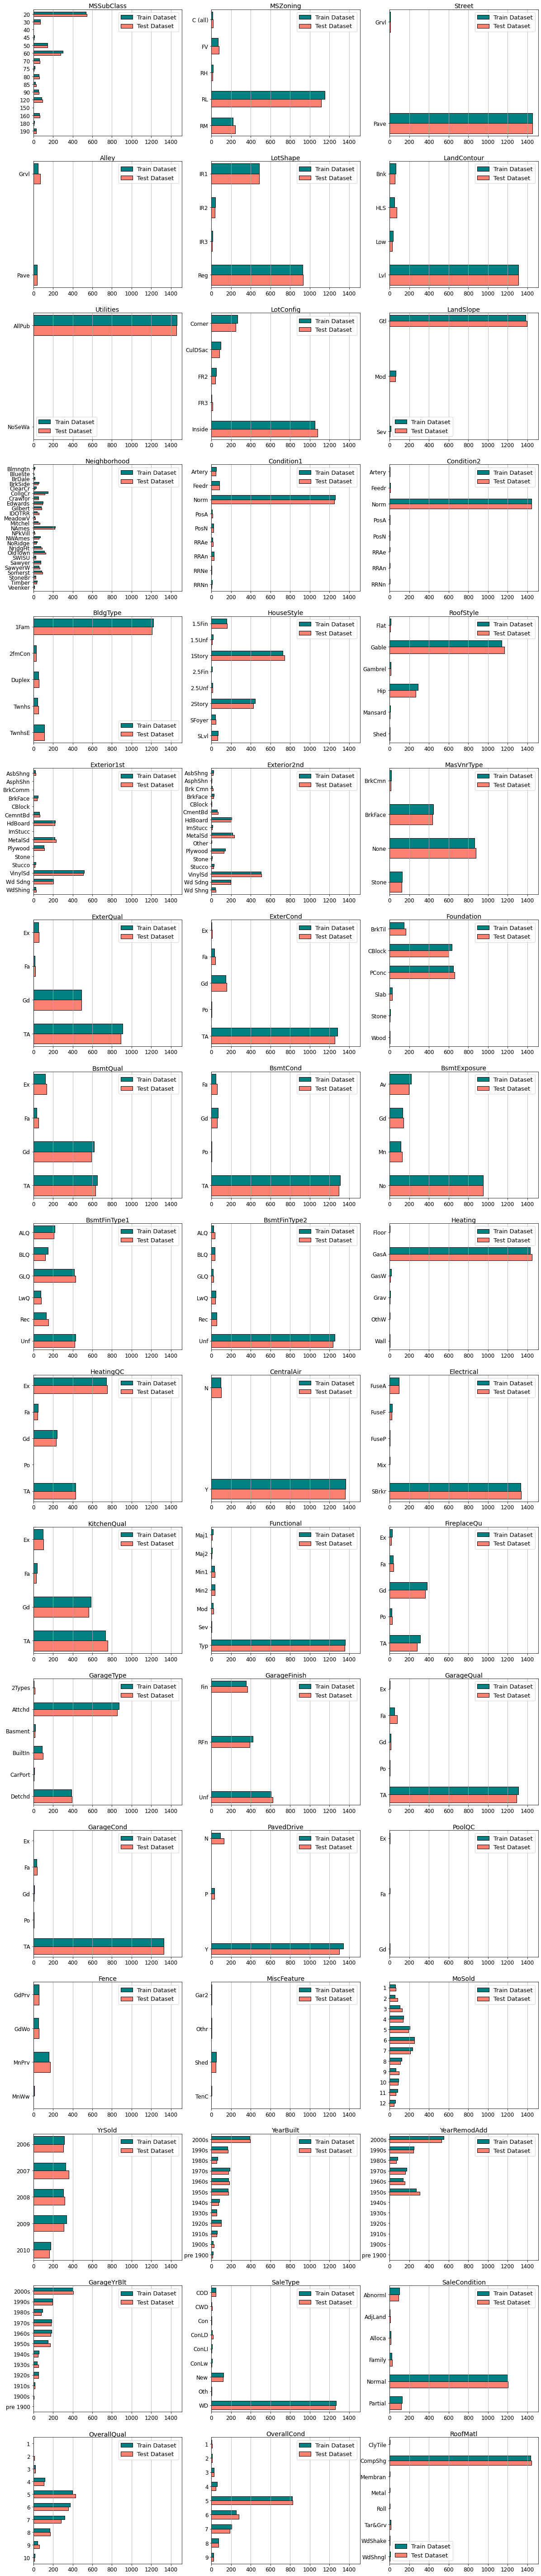

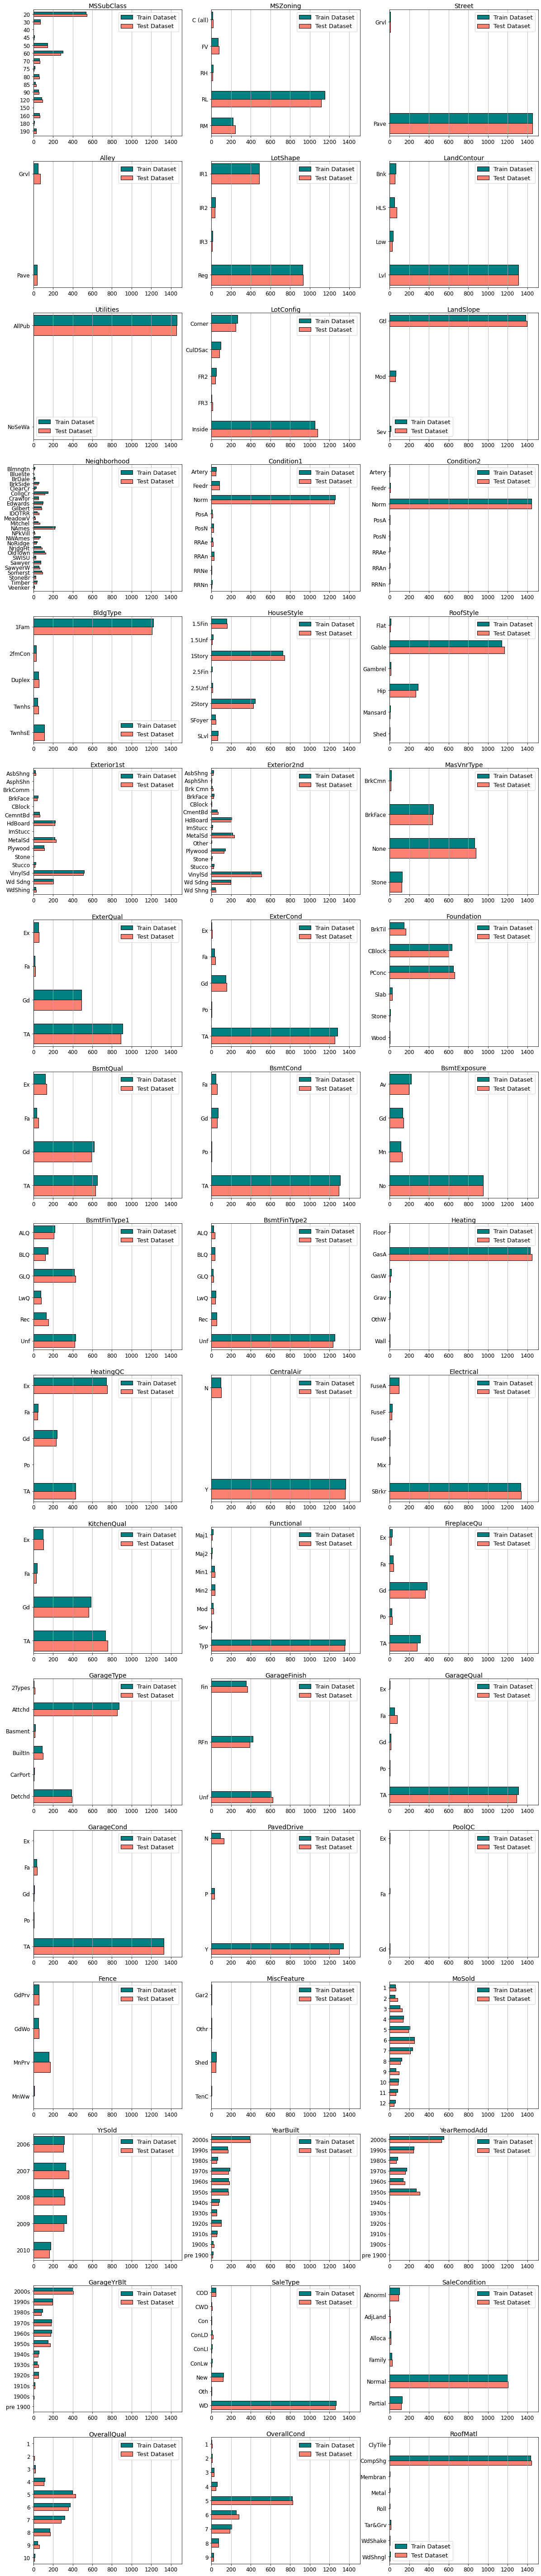

In [27]:
cols = 3
rows = len(cat_features) // cols + 1

decades = [-np.inf, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, np.inf]
decades_labels = ["pre 1900", "1900s", "1910s", "1920s", "1930s", "1940s", "1950s",
                  "1960s", "1970s", "1980s", "1990s", "2000s",]

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,110), sharex=False)
plt.subplots_adjust(hspace = 0.2)
i=0

df = pd.concat([train.drop("SalePrice", axis=1), test], axis=0)

for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(cat_features):
            axs[r, c].set_visible(False)
        else:

            # For "YearBuilt", "YearRemodAdd" and "GarageYrBlt" features I need to group
            # years into decades in order to make plots more readable
            if cat_features[i] not in ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]:
                values = df[cat_features[i]].value_counts().sort_index(ascending=False).index
                bars_pos = np.arange(0, len(values))
                if len(values)<4:
                    height=0.1
                else:
                    height=0.3

                bars1 = axs[r, c].barh(bars_pos+height/2,
                                       [train[train[cat_features[i]]==x][cat_features[i]].count() for x in values],
                                       height=height,
                                       color="teal",
                                       edgecolor="black",
                                       label="Train Dataset")
                bars2 = axs[r, c].barh(bars_pos-height/2,
                                       [test[test[cat_features[i]]==x][cat_features[i]].count() for x in values],
                                       height=height,
                                       color="salmon",
                                       edgecolor="black",
                                       label="Test Dataset")
                y_labels = [str(x) for x in values]
            else:
                height=0.3
                bars_pos = np.arange(0, len(decades_labels))
                bars1 = axs[r, c].barh(bars_pos+height/2,
                                       pd.cut(train[cat_features[i]], decades, right=False).value_counts().sort_index(ascending=True).values,
                                       height=height,
                                       color="teal",
                                       edgecolor="black",
                                       label="Train Dataset")
                bars2 = axs[r, c].barh(bars_pos-height/2,
                                       pd.cut(test[cat_features[i]], decades, right=False).value_counts().sort_index(ascending=True).values,
                                       height=height,
                                       color="salmon",
                                       edgecolor="black",
                                       label="Test Dataset")
                y_labels = decades_labels

            axs[r, c].set_title(cat_features[i], fontsize=14, pad=1)
            axs[r, c].set_xlim(0, len(train["Id"])+50)
            axs[r, c].set_yticks(bars_pos)
            axs[r, c].set_yticklabels(y_labels)
            axs[r, c].tick_params(axis="y", labelsize=12)
            axs[r, c].tick_params(axis="x", labelsize=12)
            axs[r, c].grid(axis="x")
            axs[r, c].legend(fontsize=13)
            axs[r, c].margins(0.1, 0.02)

        i+=1

# plt.suptitle("Categorical values distribution in both datasets", y=0.99)

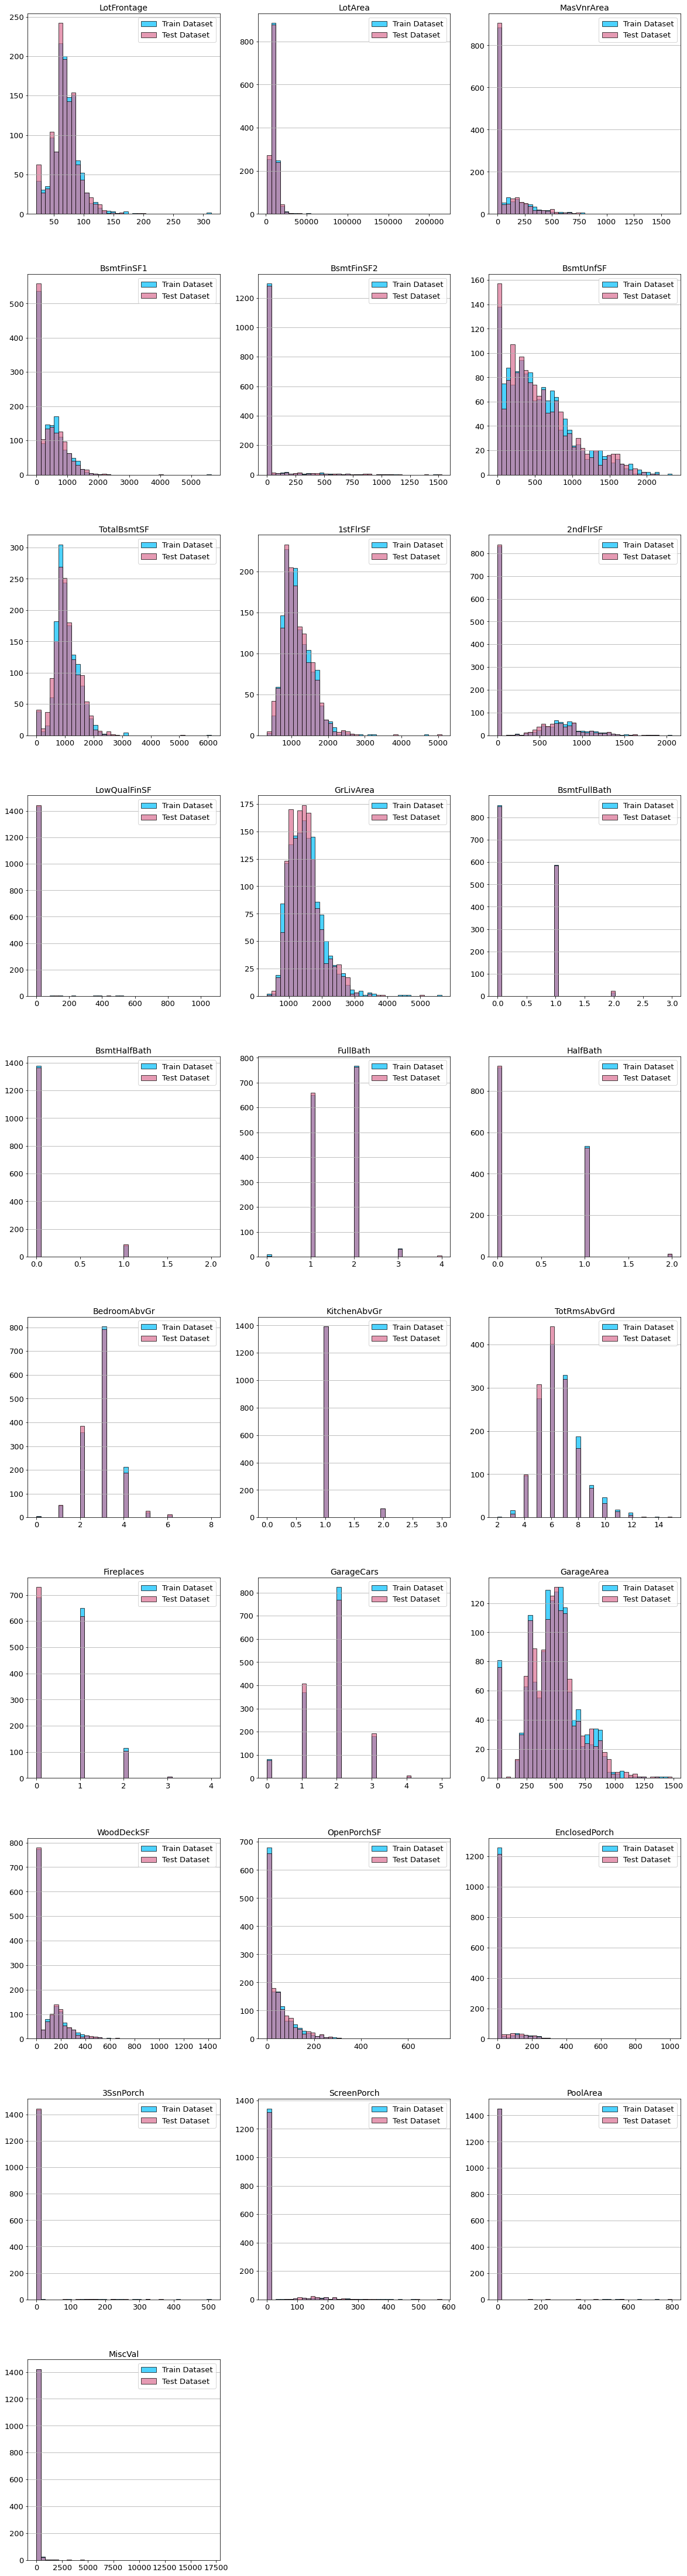

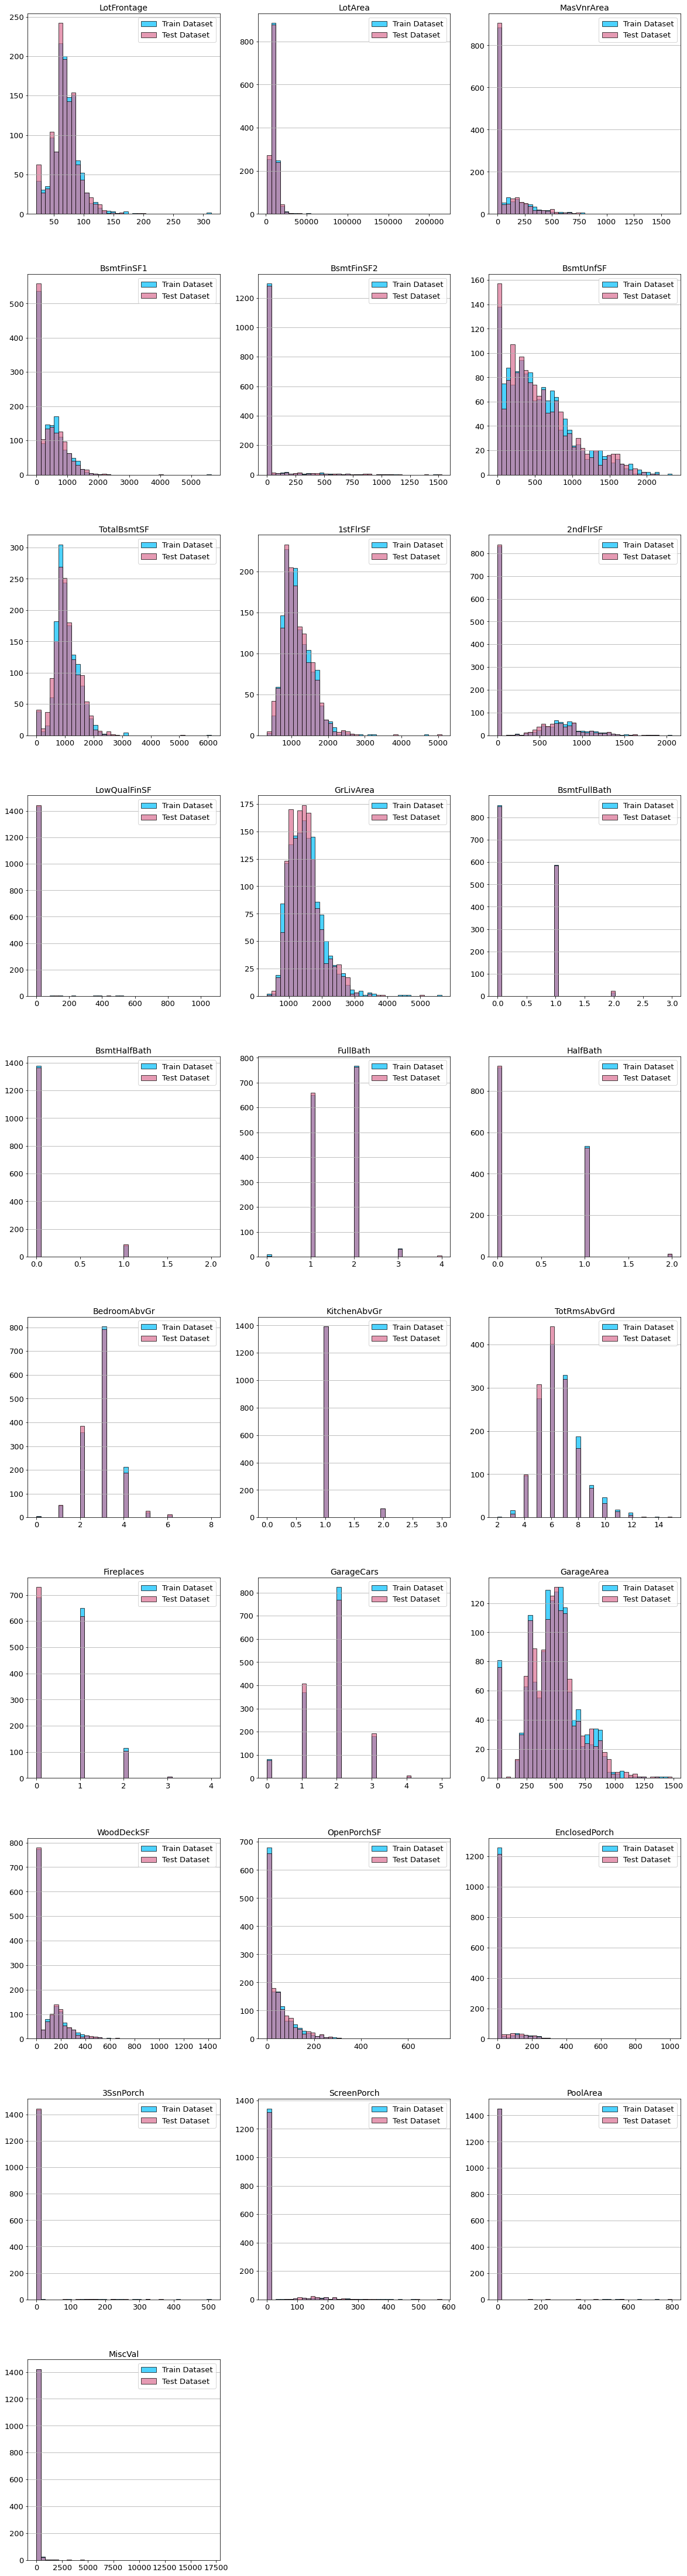

In [29]:
cols = 3
rows = len(num_features) // cols + 1

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,80), sharex=False)

plt.subplots_adjust(hspace = 0.3)
i=0

df = pd.concat([train.drop("SalePrice", axis=1), test], axis=0)

for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(num_features):
            axs[r, c].set_visible(False)
        else:
            hist1 = axs[r, c].hist(train[num_features[i]].values,
                                   range=(df[num_features[i]].min(),
                                          df[num_features[i]].max()),
                                   bins=40,
                                   color="deepskyblue",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Train Dataset")
            hist2 = axs[r, c].hist(test[num_features[i]].values,
                                   range=(df[num_features[i]].min(),
                                          df[num_features[i]].max()),
                                   bins=40,
                                   color="palevioletred",
                                   edgecolor="black",
                                   alpha=0.7,
                                   label="Test Dataset")
            axs[r, c].set_title(num_features[i], fontsize=14, pad=5)
            axs[r, c].tick_params(axis="y", labelsize=13)
            axs[r, c].tick_params(axis="x", labelsize=13)
            axs[r, c].grid(axis="y")
            axs[r, c].legend(fontsize=13)

        i+=1
plt.show();
# plt.suptitle("Numerical values distribution in both datasets", y=0.99)

In [30]:
test[test["GarageYrBlt"] > 2010]["GarageYrBlt"]

1132    2207.0
Name: GarageYrBlt, dtype: float64

In [31]:
test.loc[test["GarageYrBlt"] > 2010, "GarageYrBlt"] = 2007

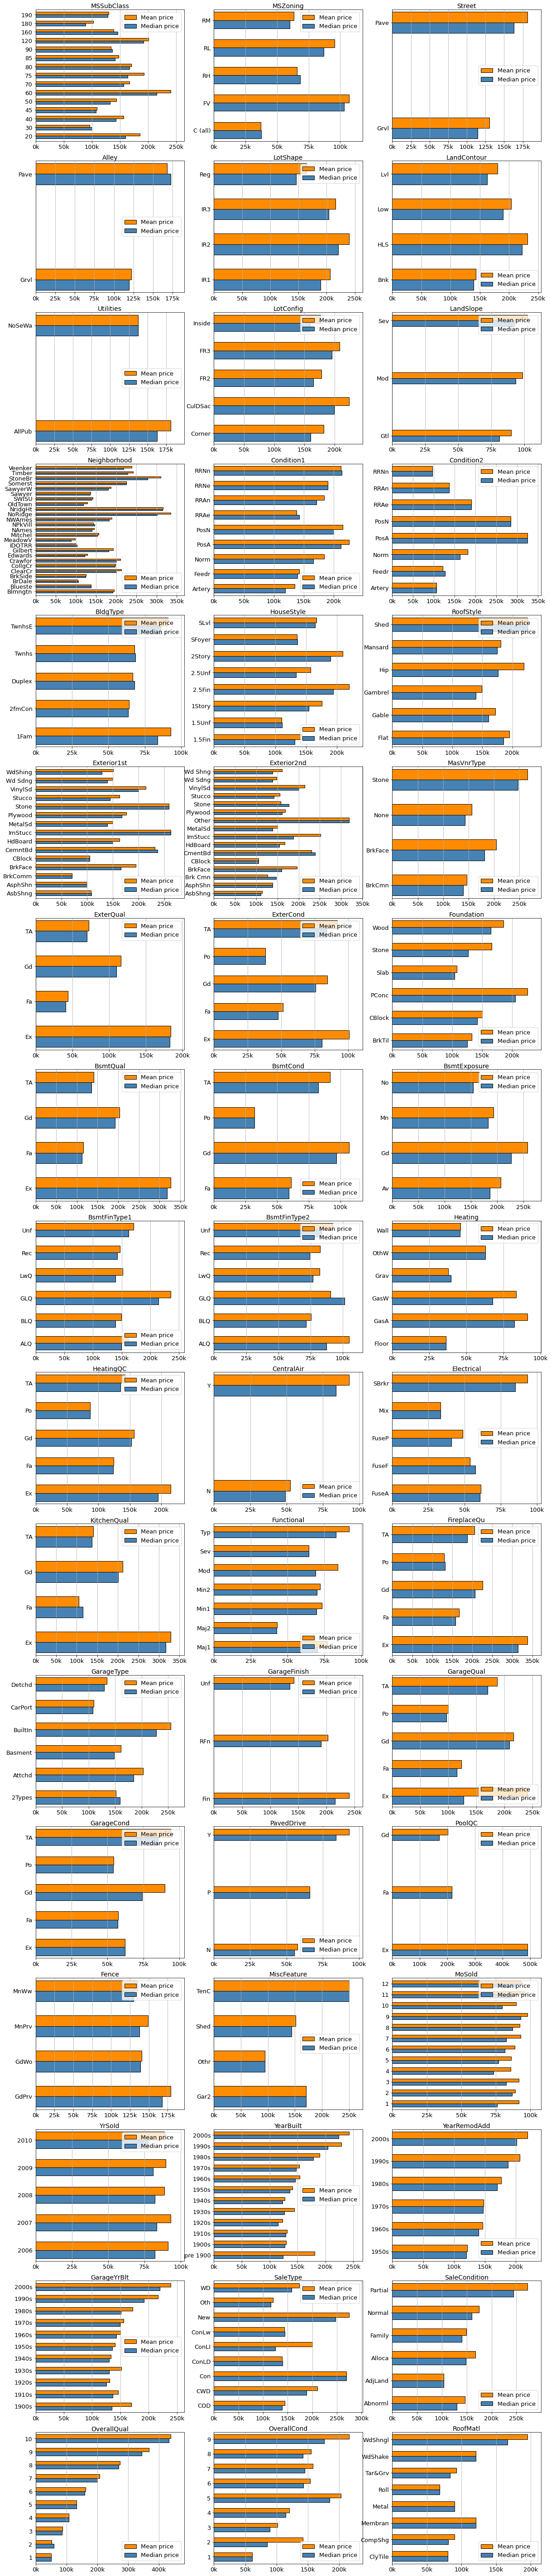

<ipython-input-33-554e1fb97e44>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[r, c].set_xticklabels([str(int(x/1000))+"k" for x in axs[r, c].get_xticks()])


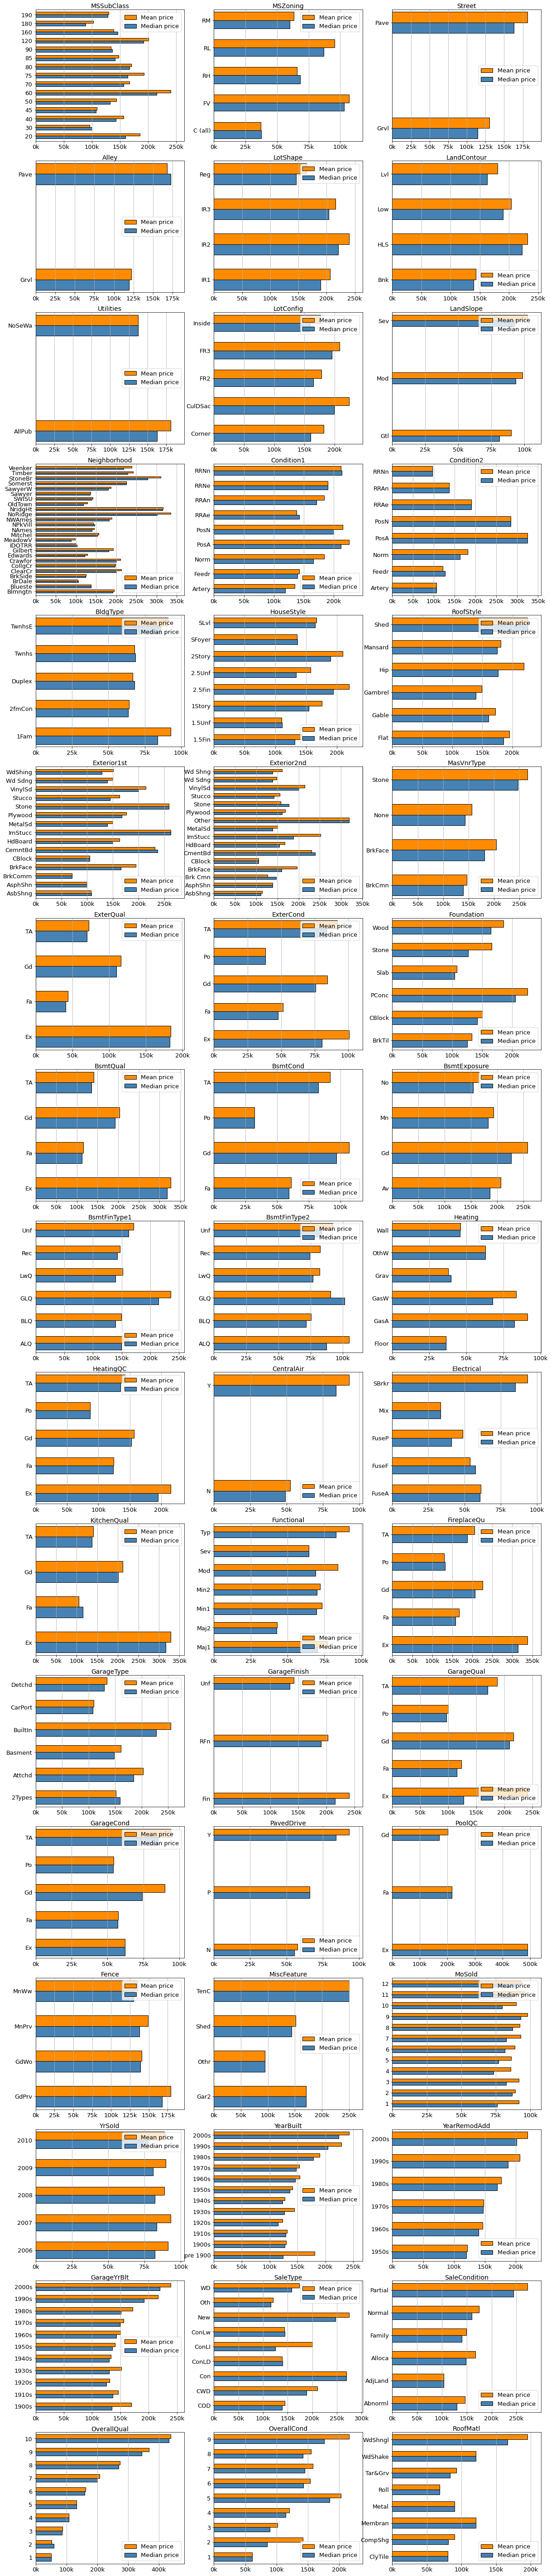

In [33]:
cols = 3
rows = len(cat_features) // cols + 1

decades = [-np.inf, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, np.inf]
decades_labels = ["pre 1900", "1900s", "1910s", "1920s", "1930s", "1940s", "1950s",
                  "1960s", "1970s", "1980s", "1990s", "2000s",]

fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(20,110), sharex=False)
plt.subplots_adjust(hspace = 0.15)
i=0

for r in np.arange(0, rows, 1):
    for c in np.arange(0, cols, 1):
        if i >= len(cat_features):
            axs[r, c].set_visible(False)
        else:

            # For "YearBuilt", "YearRemodAdd" and "GarageYrBlt" features I need to group
            # years into decades in order to make plots more readable
            if cat_features[i] not in ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]:
                bars_pos = np.arange(0, train[cat_features[i]].nunique())
                if len(bars_pos)<4:
                    height=0.1
                else:
                    height=0.3

                bars1 = axs[r, c].barh(bars_pos+height/2,
                                       train.groupby(cat_features[i])["SalePrice"].mean(),
                                       height=height,
                                       color="darkorange",
                                       edgecolor="black",
                                       label="Mean price")
                bars2 = axs[r, c].barh(bars_pos-height/2,
                                       train.groupby(cat_features[i])["SalePrice"].median(),
                                       height=height,
                                       color="steelblue",
                                       edgecolor="black",
                                       label="Median price")
                y_labels = [str(x) for x in train.groupby(cat_features[i])["SalePrice"].mean().index]
            else:
                height=0.3
                bars_pos = np.arange(0, len(decades_labels))
                values = pd.concat([pd.cut(train[cat_features[i]], decades, right=False), train["SalePrice"]], axis=1).groupby(cat_features[i])["SalePrice"]
                bars1 = axs[r, c].barh(bars_pos+height/2,
                                       values.mean(),
                                       height=height,
                                       color="darkorange",
                                       edgecolor="black",
                                       label="Mean price")
                bars2 = axs[r, c].barh(bars_pos-height/2,
                                       values.median(),
                                       height=height,
                                       color="steelblue",
                                       edgecolor="black",
                                       label="Median price")

                y_labels = decades_labels

            axs[r, c].set_title(cat_features[i], fontsize=14, pad=1)
            axs[r, c].set_yticks(bars_pos)
            axs[r, c].set_yticklabels(y_labels)
            axs[r, c].set_xticklabels([str(int(x/1000))+"k" for x in axs[r, c].get_xticks()])
            axs[r, c].tick_params(axis="y", labelsize=13)
            axs[r, c].tick_params(axis="x", labelsize=13)
            axs[r, c].grid(axis="x")
            axs[r, c].legend(fontsize=13)
            axs[r, c].margins(0.1, 0.02)

        i+=1

# plt.suptitle("Mean and medean prices distribution per categorical feature", y=0.99)

In [37]:
def prepare_train_data(df, cat_features, num_features, fill_NA, fill_zeros, to_drop):

    df.drop(to_drop, axis=1, inplace=True)

    # Filling NaN values with "NA" string
    for column in fill_NA:
        df[column].fillna("NA", inplace=True)

    # Filling NaN values with zeros
    for column in fill_zeros:
        df[column].fillna(value=0, inplace=True)

    # Filling NaN values with different values basing on feature description
    df["Electrical"].fillna(value="SBrkr", inplace=True)
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)

    # Replacing for unification
    df["MasVnrType"].replace("None", "NA", inplace=True)

    # Adding additional features
    df["Was_remodeled"] = df["YearBuilt"]!=df["YearRemodAdd"]
    df["House_age"] = df["YrSold"] - df["YearBuilt"]
    df["House_remodel_age"] = df["YrSold"] - df["YearRemodAdd"]
    df["Garage_age"] = df["YrSold"] - df["GarageYrBlt"]

    # Combining date features into 10-year intervals. It helped to improve the score.
    decades = [-np.inf, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, np.inf]
    for column in ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]:
        df[column] = pd.cut(df[column], decades, right=False)

    # Encoding categorical features and adding each trained encoder to a list so it could be used to transform test data
    encoders = []
    for column in cat_features:
        encoder = LabelEncoder()
        df[column] = encoder.fit_transform(df[column])
        encoders.append(encoder)

    # Scaling numerical features and adding each trained scaler to a list so it could be used to transform test data
    scalers = []
    for column in num_features:
        scaler = MinMaxScaler()
        df[column] = scaler.fit_transform(np.array(df[column]).reshape(-1, 1))
        scalers.append(scaler)

    return df, encoders, scalers


def prepare_test_data(df, cat_features, num_features, fill_NA,
                      encoders, scalers, fill_zeros, to_drop):

    df.drop(to_drop, axis=1, inplace=True)

    # Filling NaN values with "NA" string
    for column in fill_NA:
        df[column].fillna("NA", inplace=True)

    # Filling NaN values with zeros
    for column in fill_zeros:
        df[column].fillna(value=0, inplace=True)

    # Filling NaN values with different values basing on feature description
    df["Electrical"].fillna(value="SBrkr", inplace=True)
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)

    # Replacing for unification
    df["MasVnrType"].replace("None", "NA", inplace=True)

    # Adding additional features
    df["Was_remodeled"] = df["YearBuilt"]!=df["YearRemodAdd"]
    df["House_age"] = df["YrSold"] - df["YearBuilt"]
    df["House_remodel_age"] = df["YrSold"] - df["YearRemodAdd"]
    df["Garage_age"] = df["YrSold"] - df["GarageYrBlt"]

    # Combining date features into 10-year intervals. It helped to improve the score.
    decades = [-np.inf, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, np.inf]
    for column in ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]:
        df[column] = pd.cut(df[column], decades, right=False)

    for i, column in enumerate(cat_features):

        # Getting an encoder from trained encoders list
        encoder = encoders[i]

        # Creating a temporary encoder and fitting it to the test data
        temp_encoder = LabelEncoder()
        temp_encoder.fit(df[column])
        # Checking if test data has some categories missing in train data
        for element in temp_encoder.classes_:
            if element not in encoder.classes_:
                # Adding previously unseen categories to a trained encoder dictionary
                # in order to avoid errors during transformation
                encoder.classes_ = np.append(encoder.classes_, element)

        # Transforming test data using an encoder with updated categories dictionary
        df[column] = encoder.transform(df[column])

    # Getting trained scalers from a list and using it to transform test data
    for i, column in enumerate(num_features):
        scaler = scalers[i]
        df[column] = scaler.transform(np.array(df[column]).reshape(-1, 1))

    return df

In [38]:
# Adding names of new features to categorical and numerical features lists
cat_features.append("Was_remodeled")
num_features.append("House_age")
num_features.append("House_remodel_age")
num_features.append("Garage_age")

# A list of features to be dropped from the datasets because they have too many NaN values. It helped to imporve the score.
to_drop = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]

print(f"Cat_features length before dropping features: {len(cat_features)}")
print(f"Num_features length before dropping features: {len(num_features)}")
print(f"Fill_zeros length before dropping features: {len(fill_zeros)}")
print(f"Fill_NA length before dropping features: {len(fill_NA)}")

# Removing feature names from the feature lists
for column in to_drop:
    if column in cat_features:
        cat_features.remove(column)
    else:
        num_features.remove(column)
    if column in fill_zeros:
        fill_zeros.remove(column)
    elif column in fill_NA:
        fill_NA.remove(column)

print(f"Cat_features length after dropping features: {len(cat_features)}")
print(f"Num_features length after dropping features: {len(num_features)}")
print(f"Fill_zeros length after dropping features: {len(fill_zeros)}")
print(f"Fill_NA length after dropping features: {len(fill_NA)}")

Cat_features length before dropping features: 52
Num_features length before dropping features: 31
Fill_zeros length before dropping features: 10
Fill_NA length before dropping features: 22
Cat_features length after dropping features: 47
Num_features length after dropping features: 31
Fill_zeros length after dropping features: 10
Fill_NA length after dropping features: 17


In [39]:
# Calling the functions to transform train and test data sets
train_data, encoders, scalers = prepare_train_data(train.drop(["SalePrice", "Id"], axis=1),
                                                   cat_features, num_features, fill_NA,
                                                   fill_zeros, to_drop)

display(train_data.head())

test_data = prepare_test_data(test.drop("Id", axis=1), cat_features,
                              num_features, fill_NA, encoders, scalers, fill_zeros, to_drop)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Was_remodeled,House_age,House_remodel_age,Garage_age
0,5,3,0.150685,0.033420,1,3,3,0,4,0,...,0.0,0.0,1,2,8,4,0,0.036765,0.098361,0.002488
1,0,3,0.202055,0.038795,1,3,3,0,2,0,...,0.0,0.0,4,1,8,4,0,0.227941,0.524590,0.015423
2,5,3,0.160959,0.046507,1,0,3,0,4,0,...,0.0,0.0,8,2,8,4,1,0.051471,0.114754,0.003483
3,6,3,0.133562,0.038561,1,0,3,0,0,0,...,0.0,0.0,1,0,8,0,1,0.669118,0.606557,0.003980
4,5,3,0.215753,0.060576,1,0,3,0,2,0,...,0.0,0.0,11,2,8,4,0,0.058824,0.147541,0.003980


In [40]:
df = pd.concat([train_data.isna().sum(), test_data.isna().sum()], axis=1)
df.sum()


0    0
1    0
dtype: int64

In [41]:
X_train = train_data
y_train = train["SalePrice"]

In [43]:
# A function to train all base-models and the blender
def train_estimators(models, blender, X_train, y_train):
    trained_models = []
    cols = [type(x).__name__ for x in models]
    preds = pd.DataFrame(columns=cols)

    for model in models:
        model.fit(X_train, y_train)
        preds[str(type(model).__name__)] = model.predict(X_train)
        trained_models.append(model)


    blender.fit(preds, y_train)
    preds["blender"] = blender.predict(preds)

    return trained_models, blender

# A function to get predictions by the base-models and the blender
def get_predictions(X_test, trained_models, blender):
    cols = [type(x).__name__ for x in models]
    preds = pd.DataFrame(columns=cols)

    for model in models:
        preds[str(type(model).__name__)] = model.predict(X_test)
    preds["blender"] = blender.predict(preds)

    return preds["blender"]

In [45]:
models = [
          RandomForestRegressor(criterion='mse',
                                max_depth=20,
                                max_features='sqrt',
                                min_samples_leaf=1,
                                min_samples_split=4,
                                n_estimators=250,
                                n_jobs=-1,
                                random_state=42),
          CatBoostRegressor(depth=4,
                            iterations=1000,
                            learning_rate=0.1,
                            max_ctr_complexity=1,
                            min_data_in_leaf=1,
                            thread_count=4,
                            verbose=0)
          ]

# A meta-model which will be trained on base-models' predictions.
blender = Ridge(random_state=42)

models, blender = train_estimators(models, blender, X_train, y_train)

preds = get_predictions(test_data, models, blender)

<ipython-input-46-673807bb034e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df["Feature"][:10], fontsize=15)


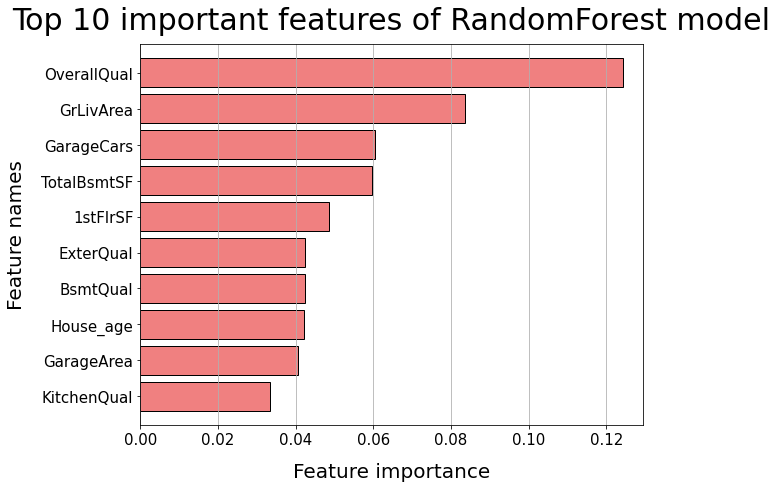

In [46]:
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = train_data.columns
df["Importance"] = models[0].feature_importances_
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(9, 7))
bars = ax.barh(df["Feature"][:10], df["Importance"][:10],
               color="lightcoral", edgecolor="black")
ax.set_title("Top 10 important features of RandomForest model", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticklabels(df["Feature"][:10], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
plt.margins(0.04, 0.04)
plt.gca().invert_yaxis()

<ipython-input-47-e8aeee488499>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df["Feature"][:10], fontsize=15)


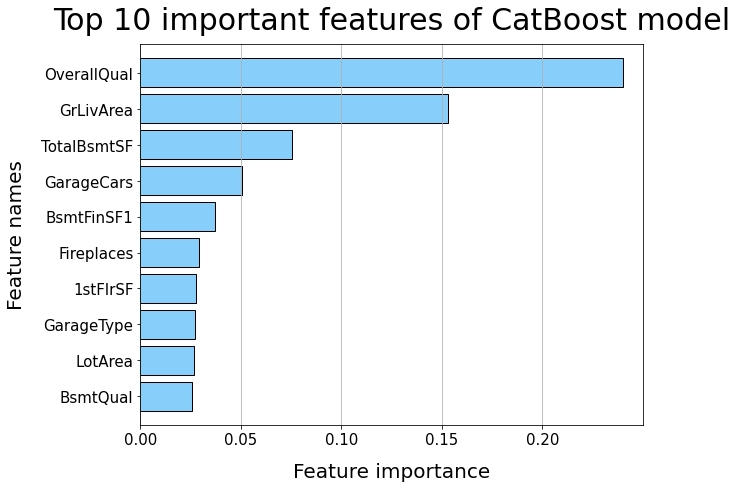

In [47]:
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = train_data.columns
df["Importance"] = models[1].feature_importances_ / 100
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(9, 7))
bars = ax.barh(df["Feature"][:10], df["Importance"][:10],
               color="lightskyblue", edgecolor="black")
ax.set_title("Top 10 important features of CatBoost model", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticklabels(df["Feature"][:10], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
plt.margins(0.04, 0.04)
plt.gca().invert_yaxis()


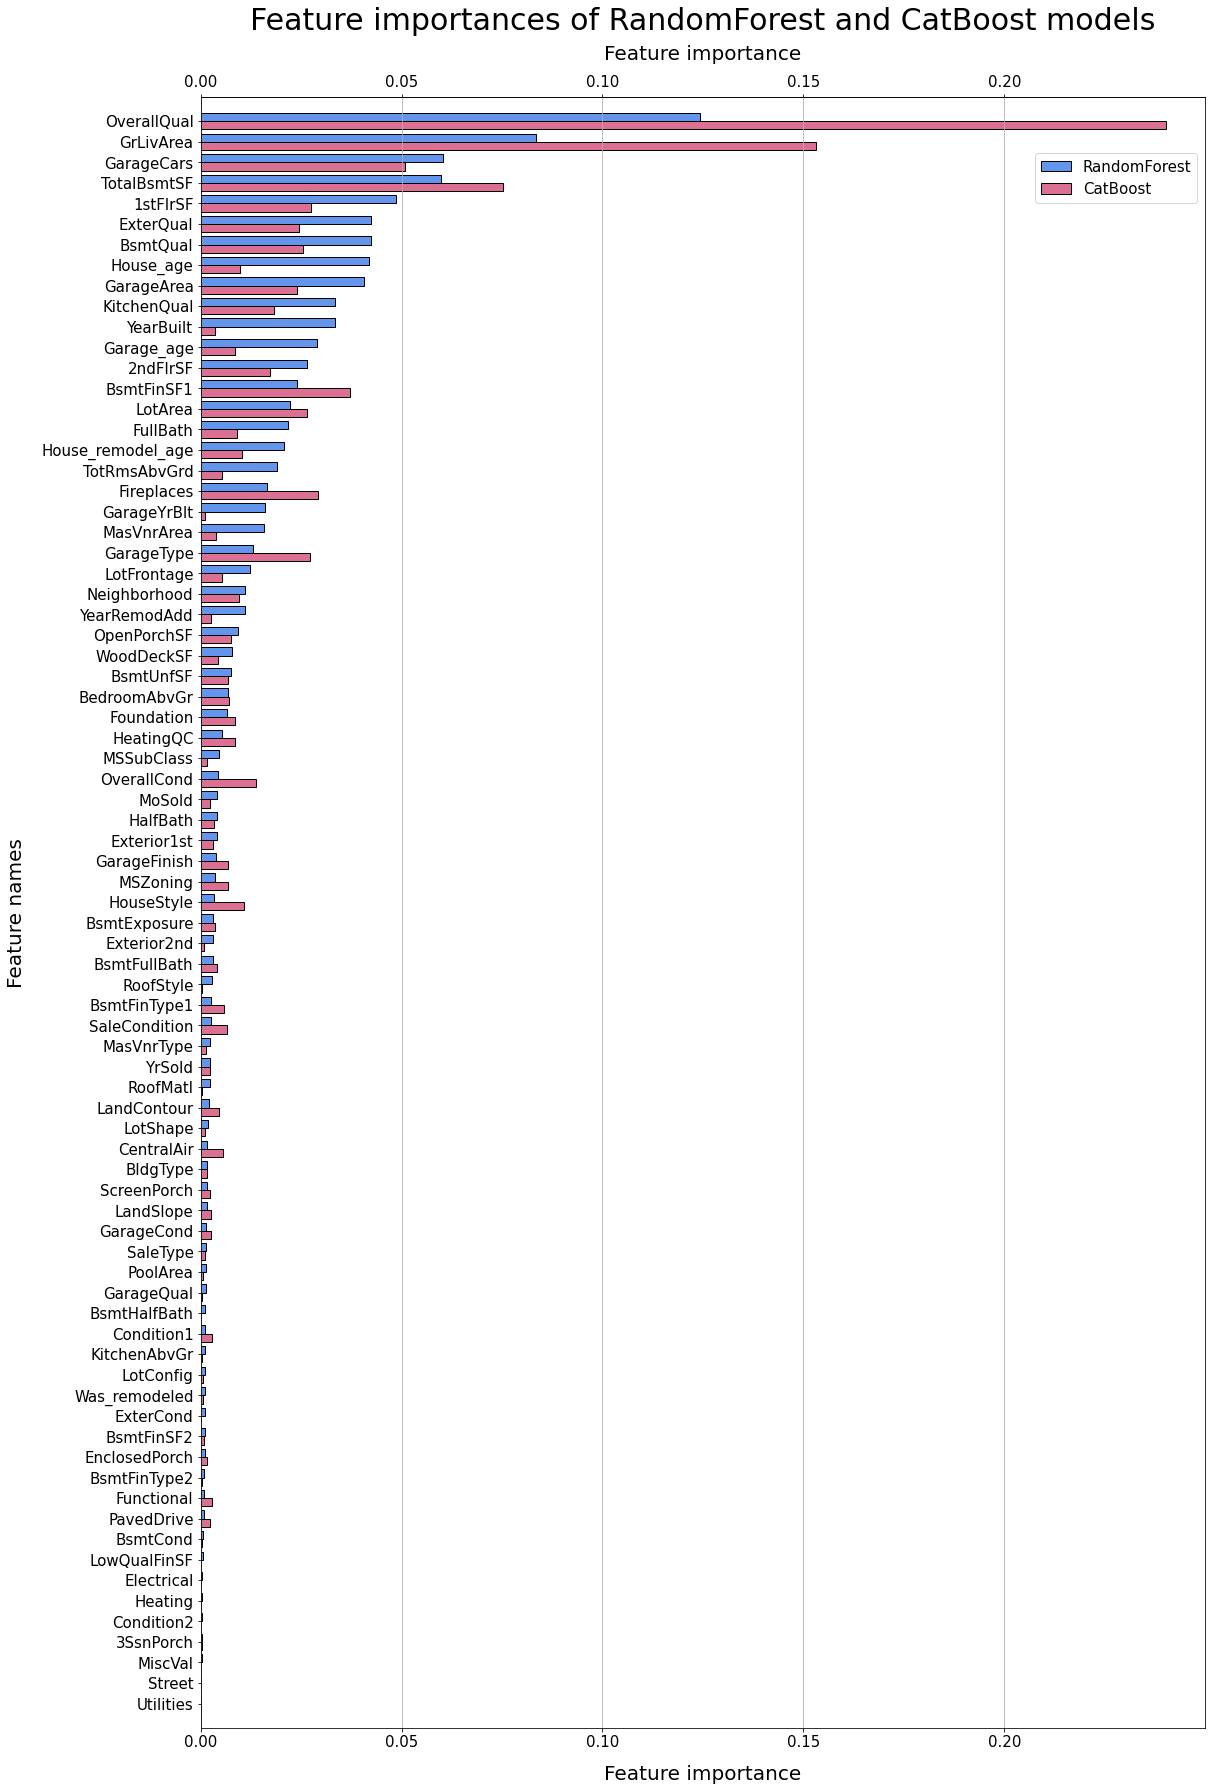

In [48]:
df = pd.DataFrame(columns=["Feature", "Importance_rf", "Importance_cb"])
df["Feature"] = train_data.columns
df["Importance_rf"] = models[0].feature_importances_
df["Importance_cb"] = models[1].feature_importances_ / 100
df.sort_values("Importance_rf", axis=0, ascending=False, inplace=True)

x = np.arange(0, len(df["Feature"]))
height = 0.4

fig, ax = plt.subplots(figsize=(18, 30))
bars1 = ax.barh(x-height/2, df["Importance_rf"], height=height,
                color="cornflowerblue", edgecolor="black", label="RandomForest")
bars2 = ax.barh(x+height/2, df["Importance_cb"], height=height,
                color="palevioletred", edgecolor="black", label="CatBoost")
ax.set_title("Feature importances of RandomForest and CatBoost models", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
# ax.set_xlim(0, 0.25)
# ax.set_xticks(np.arange(0, 0.275, 0.025))
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax2 = ax.secondary_xaxis('top')
ax2.set_xlabel("Feature importance", fontsize=20, labelpad=15)
# ax2.set_xlim(0, 0.25)
# ax2.set_xticks(np.arange(0, 0.275, 0.025))
ax2.tick_params(axis="x", labelsize=15)
ax.legend(fontsize=15, loc=1, bbox_to_anchor=(0, 0, 1, 0.97))
plt.margins(0.04, 0.01)
plt.gca().invert_yaxis()

In [49]:
predictions = pd.DataFrame()
predictions["Id"] = test["Id"]
predictions["SalePrice"] = preds
predictions.to_csv('submission.csv', index=False,
                   header=["Id", "SalePrice"],
                   columns=["Id", "SalePrice"])
predictions.head()

,Id,SalePrice
0,1461,127256.673362
1,1462,160787.519615
2,1463,181101.862688
3,1464,187620.653103
4,1465,184980.886152
